In [1]:
import os
import time
import warnings
import itertools
import numpy as np
import cvxpy as cp
import pandas as pd
from tqdm import tqdm
from scipy.linalg import orth
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
from matplotlib.ticker import LogFormatter
# from surprise import Dataset, Reader, SVD, accuracy
# from surprise.model_selection import train_test_split
np.random.seed(29)
warnings.filterwarnings("ignore")

In [ ]:
# def generate_action_set(trials, M, d, k):
    
#     complete_rating = pd.read_csv('complete_ratings').values[:, 1:] / 5

#     model = NMF(n_components = int(np.sqrt(d)), init = 'nndsvda', max_iter = 10000)
#     W = model.fit_transform(complete_rating)
#     H = model.components_

#     theta_true = np.eye(int(np.sqrt(d))).ravel()
#     Theta = np.tile(theta_true, (M, 1)).T[np.newaxis, :]

#     kmeans = KMeans(n_clusters = M, random_state = 0).fit(H.T)
#     labels = kmeans.labels_

#     Action_list = np.empty((1, W.shape[0], M), dtype = object)

#     for t in range(W.shape[0]):

#         for i in range(M):

#             size = H[:, labels == i].shape[1]
#             Action_list[0, t, i] = np.empty((size, d), dtype = object)

#             for ac in range(size):

#                 temp = np.outer(W[t], H[:, labels == i][:, ac])
#                 Action_list[0, t, i][ac] = temp.ravel()
                
#     return Action_list, Theta

In [2]:
def generate_action_set(d):
    
    complete_rating = pd.read_csv('complete_ratings').values[:, 1:] / 5
    
    model = NMF(n_components = d, init = 'nndsvda', max_iter = 10000)
    W = model.fit_transform(complete_rating)
    H = model.components_
    W = W[:15]
    # H = H[:, :50]
    
    A = np.zeros((W.shape[0], H.shape[1], d))
    Theta = np.zeros((d, W.shape[0]))
    
    for i in range(W.shape[0]):
    
        Theta[:, i] = np.ones(d)
        
        for j in range(H.shape[1]):
    
            A[i, j] = W[i] * H[:, j]

    L_list = []

    for i in range(W.shape[0]):

        norm_list = np.linalg.norm(A[-1], axis=1)
        L_list.append(norm_list)

    L = np.max(L_list)
    S = np.linalg.norm(Theta[:, -1])
                
    return A, Theta, L, S

In [3]:
def init_altgdmin(X, t, Y, C, M, d, k):
    
    alpha = C * np.linalg.norm(Y, 'fro') / np.sqrt(t * M)
    Y_trunc = np.where(np.abs(Y) > alpha, 0, Y)
    
    Theta_0 = np.zeros((d, M))
    
    for i in range(M):
        
        Theta_0[:, i] = np.sum(X[i].dot(np.diag(Y_trunc[i])), axis=1) / t
    
    U_0, Sigma_0, V_0 = np.linalg.svd(Theta_0, full_matrices = False)
    B_hat = U_0[:, :k]
    S_k = np.zeros((k, k))
    np.fill_diagonal(S_k, Sigma_0[:k])
    
    return B_hat

In [4]:
def AltGD_Min(X, Y, M, k, B_hat):
    
    W_hat = np.zeros((k, M))
    
    for i in range(M):

        W_hat[:, i] = np.linalg.lstsq(np.dot(X[i].T, B_hat), Y[i], rcond = None)[0]
    
    return W_hat

In [5]:
def cella_estimator(M, d, iterations, delta, sigma, Y, X, t):

    C = 1
    temp = np.sqrt((M + d + np.log(4 * iterations / delta)) * (np.log(8 * iterations * (d + M) / delta) ** 3))
    lambda_n = sigma * np.sqrt((d + M) * np.log(2 * iterations * (d + M) / delta) * C * temp / t)

    Theta_hat = cp.Variable((d, M))

    loss = 0

    for i in range(M):

        Xt = X[i].T
        yt = cp.Constant(Y[i])
        pred = Xt @ Theta_hat[:, i]
        loss += cp.sum_squares(pred - yt)

    regularization = cp.norm(Theta_hat, 'nuc')
    objective = cp.Minimize(1 / t * loss + lambda_n * regularization)
    prob = cp.Problem(objective)
    prob.solve(solver=cp.SCS)

    return Theta_hat.value

In [6]:
CR_Trials_ICML = []
CR_Trials_E2TC = []
CR_Trials_Naive = []
CR_Trials_Cella = []
d = 100
k = 1
C = 3
R = 1
ld = 1
ld_0 = 1
trials = 1
sigma = 1e-1
delta = 1e-3
epoch_iter = 20
iterations = 100
every_point = 25
A, Theta, L, S = generate_action_set(d)
M = A.shape[0]
num_action = A.shape[1]

In [7]:
# generate the noise of reward for each iteration
noise_list = np.random.normal(0, sigma, size = (iterations, M))

In [8]:
action_exploration_list = np.random.choice(num_action, (epoch_iter, M))

In [9]:
# ICML
start = time.time()

action_set = A
Theta_star = Theta
noise_T = noise_list

B_hat = np.zeros((d, k))
W_hat = np.zeros((k, M))
Theta_hat = B_hat.dot(W_hat)

cumulative_regret = 0
cummulative_regret_list = [0]

X = [np.empty((d, epoch_iter)) for _ in range(M)]
Y = [np.empty(epoch_iter) for _ in range(M)]
    
for t in tqdm(range(epoch_iter), desc = 'exploration iterations'):

    for i in range(M):

        action = action_exploration_list[t, i]
        reward = action_set[i, action].dot(Theta_star[:, i])
        cumulative_regret += np.max(action_set[i].dot(Theta_star[:, i])) - reward

        X[i][:, t] = action_set[i, action].reshape(-1)
        Y[i][t] = reward + noise_T[t, i]

    cummulative_regret_list.append(cumulative_regret)

B_hat = init_altgdmin(X, epoch_iter, Y, C, M, d, k)
W_hat = AltGD_Min(X, Y, M, k, B_hat)
Theta_hat = B_hat.dot(W_hat)

for t in tqdm(range(epoch_iter, iterations), desc = 'commit iterations'):

    for i in range(M):
        
        action = np.argmax(np.dot(action_set[i], Theta_hat[:, i]))
        reward = action_set[i, action].dot(Theta_star[:, i])
        cumulative_regret += np.max(action_set[i].dot(Theta_star[:, i])) - reward

    cummulative_regret_list.append(cumulative_regret)

CR_Trials_ICML = cummulative_regret_list
    
end = time.time()
print('Finished! The total time we use is: ', end - start)

commit iterations: 100%|██████████| 80/80 [00:00<00:00, 978.17it/s]

Finished! The total time we use is:  0.11768579483032227


In [ ]:
# INFINITE-ACTION SETTING
start = time.time()

action_set = A
Theta_star = Theta
noise_T = noise_list

B_hat = np.zeros((d, k))
W_hat = np.zeros((k, M))
Theta_hat = B_hat.dot(W_hat)

cumulative_regret = 0
cummulative_regret_list = [0]

M_hat = np.zeros((d, d))

X = [np.empty((d, epoch_iter)) for _ in range(M)]
Y = [np.empty(epoch_iter) for _ in range(M)]
    
for t in tqdm(range(epoch_iter), desc = 'exploration iterations'):

    for i in range(M):

        action = action_exploration_list[t, i]
        reward = action_set[i, action].dot(Theta_star[:, i])
        cumulative_regret += np.max(action_set[i].dot(Theta_star[:, i])) - reward

        X[i][:, t] = action_set[i, action].reshape(-1)
        Y[i][t] = reward + noise_T[t, i]

        M_hat = M_hat + (reward + noise_T[t, i]) ** 2 * np.dot(action_set[i, action].reshape(-1, 1), action_set[i, action].reshape(1, -1))

    cummulative_regret_list.append(cumulative_regret)

M_hat = M_hat / (epoch_iter * M)
M_hat = M_hat.astype(np.float64)
U, Sigma, V = np.linalg.svd(M_hat, full_matrices=False)
B_hat = U[:, :k]

for i in range(M):

    W_hat[:, i] = np.linalg.lstsq(np.dot(X[i].T, B_hat), Y[i], rcond = None)[0]

Theta_hat = B_hat.dot(W_hat)
    
for t in tqdm(range(epoch_iter, iterations), desc = 'commit iterations'):

    for i in range(M):
        
        action = np.argmax(np.dot(action_set[i], Theta_hat[:, i]))
        reward = action_set[i, action].dot(Theta_star[:, i])
        cumulative_regret += np.max(action_set[i].dot(Theta_star[:, i])) - reward
        
    cummulative_regret_list.append(cumulative_regret)
    
CR_Trials_E2TC = cummulative_regret_list
    
end = time.time()
print('Finished! The total time we use is: ', end - start)

In [ ]:
# Naive Approach
start = time.time()

action_set = A
Theta_star = Theta
noise_T = noise_list

W = np.zeros((M, d, d))
U = np.zeros((M, d, 1))

Theta_hat = np.zeros((d, M))
delta_prime = delta / (4 * iterations)

cumulative_regret = 0
cummulative_regret_list = [0]

for t in tqdm(range(iterations), desc = 'iterations'):

    for i in range(M):

        # sample eta
        eta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.eye(d))

        # compute RLS-estimate theta_hat and V
        V = ld * np.eye(d) + W[i]
        Theta_hat[:, i] = np.dot(np.linalg.inv(V), U[i]).reshape(-1)

        # compute the beta
        beta = sigma * np.sqrt(d * np.log((1 + t * (L ** 2) / ld) / delta_prime)) + np.sqrt(ld) * S

        # calculate V^{-1/2}
        eigvals, eigvecs = np.linalg.eigh(V)
        temp = eigvecs.dot(np.diag(1.0 / np.sqrt(eigvals))).dot(eigvecs.T)

        # compute theta_tilde
        theta_tilde = Theta_hat[:, i] + beta * (temp.dot(eta)).reshape(-1)
        
        action = np.argmax(np.dot(action_set[i], theta_tilde))
        feature = action_set[i, action]
        reward = feature.dot(Theta_star[:, i])
        cumulative_regret += np.max(action_set[i].dot(Theta_star[:, i])) - reward

        W[i] += np.dot(feature.reshape(-1, 1), feature.reshape(1, -1))
        U[i] += feature.reshape(-1, 1) * (reward + noise_T[t, i])

    cummulative_regret_list.append(cumulative_regret)

CR_Trials_Naive = cummulative_regret_list
    
end = time.time()
print('Finished! The total time we use is: ', end - start)

In [10]:
# Cella
start = time.time()

action_set = A
Theta_star = Theta
noise_T = noise_list

Theta_hat = np.zeros((d, M))

cumulative_regret = 0
cummulative_regret_list = [0]

X = [np.empty((d, 0)) for _ in range(M)]
Y = [np.empty(0) for _ in range(M)]

for t in tqdm(range(iterations), desc = 'iterations'):

    for i in range(M):
        
        action = np.argmax(np.dot(action_set[i], Theta_hat[:, i]))
        reward = action_set[i, action].dot(Theta_star[:, i])
        cumulative_regret += np.max(np.dot(action_set[i], Theta_star[:, i])) - reward

        X[i] = np.hstack((X[i], action_set[i, action].reshape(-1, 1)))
        Y[i] = np.append(Y[i], reward + noise_T[t, i])

    Theta_hat = cella_estimator(M, d, iterations, delta, sigma, Y, X, t + 1)

    cummulative_regret_list.append(cumulative_regret)

CR_Trials_Cella = cummulative_regret_list

end = time.time()
print('Finished! The total time we use is: ', end - start)

iterations: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]

Finished! The total time we use is:  17.74202251434326


In [11]:
def prepare_plot_data(CR_Trials, iterations, trials):
    
    x_value = np.array([i for i in range(iterations + 1)])
    y_value = np.zeros(iterations + 1)
    
    for i in range(iterations + 1):
        
        for T in range(trials):
            
            y_value[i] += CR_Trials[i]
            
    y_value = y_value / trials
            
    return x_value, y_value

In [12]:
x_proposed, y_proposed = prepare_plot_data(CR_Trials_ICML, iterations, trials)
# x_E2TC, y_E2TC = prepare_plot_data(CR_Trials_E2TC, iterations, trials)
# x_Naive, y_Naive = prepare_plot_data(CR_Trials_Naive, iterations, trials)
x_Cella, y_Cella = prepare_plot_data(CR_Trials_Cella, iterations, trials)

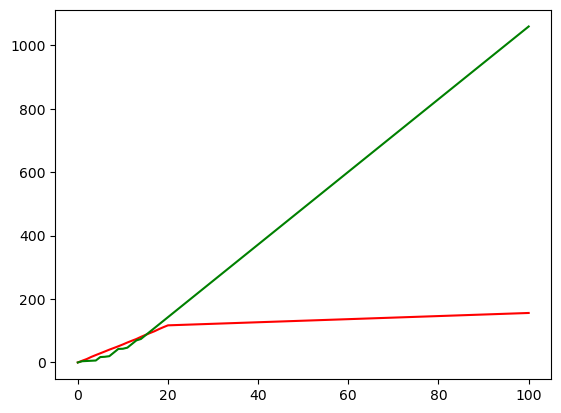

In [13]:
plt.plot(x_proposed, y_proposed, color = 'r')
# plt.plot(x_E2TC, y_E2TC, color = 'b')
# plt.plot(x_Naive, y_Naive, color = 'y')
plt.plot(x_Cella, y_Cella, color = 'g')

In [14]:
np.save('CR_Trials_ICML.npy', np.array(CR_Trials_ICML, dtype=object))
# np.save('CR_Trials_E2TC.npy', np.array(CR_Trials_E2TC, dtype=object))
# np.save('CR_Trials_Naive.npy', np.array(CR_Trials_Naive, dtype=object))
np.save('CR_Trials_Cella.npy', np.array(CR_Trials_Cella, dtype=object))